In [1]:

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

2024-04-04 10:55:41.572956: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 10:55:41.576196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 10:55:41.639412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 10:55:41.640789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:55:42.599608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
points = np.array([[1,2],[1,4],[1,0],[10,2],[10,4],[10,0]])
centroids = np.array([[1,1],[10,3]])
points_weight = np.array([1,2,3,4,5,6])

def k_means_ones(points, centroids, points_weight):
    distances = np.sqrt(((points - centroids[:,np.newaxis])**2).sum(axis=2))
    print(distances)
    
    distances_to_centroid = np.min(distances, axis=0)
    print(f"distances_to_centroid {distances_to_centroid}")

    clustered_points = np.argmin(distances, axis=0)
    print(f"clustered_points {clustered_points}")

    centroids_weight = np.zeros(len(centroids))
    
    
    for i in range(len(centroids)):
        points_in_cluster = points[clustered_points == i]
        weights_in_cluster = points_weight[clustered_points == i]
        distances_in_cluster = distances_to_centroid[clustered_points == i]
        distances_in_cluster[distances_in_cluster < 1] = 1
    
        weights_in_cluster = np.multiply(weights_in_cluster, 1./distances_in_cluster)
        
        centroids_weight[i] = np.sum(weights_in_cluster)
        print(f"centroids_weight {i} {centroids_weight[i]}")
    
    return centroids_weight
    
centroids_weight = k_means_ones(points, centroids,points_weight)
print(centroids_weight)

[[1.         3.         1.         9.05538514 9.48683298 9.05538514]
 [9.05538514 9.05538514 9.48683298 1.         1.         3.        ]]
distances_to_centroid [1. 3. 1. 1. 1. 3.]
clustered_points [0 0 0 1 1 1]
centroids_weight 0 4.666666666666666
centroids_weight 1 11.0
[ 4.66666667 11.        ]


### Use attention map

6/6 [==============================] - 0s 20ms/step


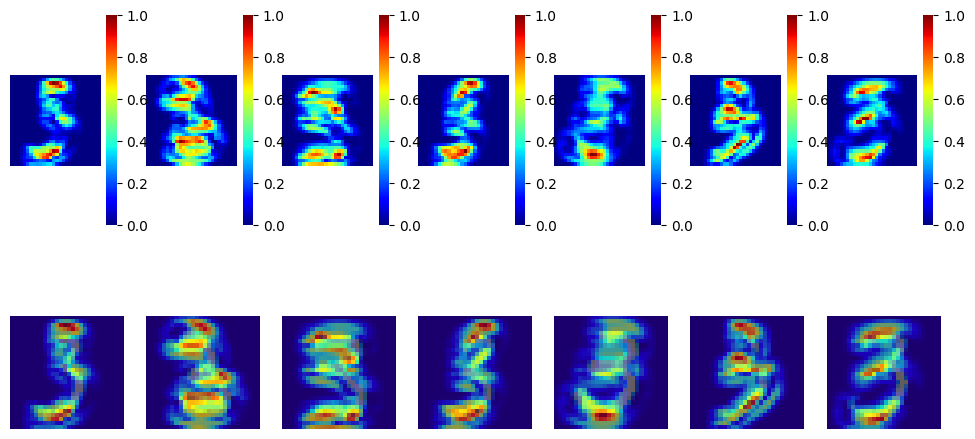

In [70]:
from population import load_mnist_test
from attention_manager import AttentionManager
import seaborn as sns
%matplotlib inline

def get_input(num, popsize):
    x_test, y_test = load_mnist_test(popsize, num)

    X = np.reshape(x_test, (popsize, 28, 28, 1))
    X = X.astype('float32')
    # X /= 255.0
    return X

popsize = 7
number = 3
ATTENTION = "Faster-ScoreCAM" #"SmoothGrad"|"VanillaSaliency"|"GradCAM"|"GradCAM++"|"ScoreCAM"|"Faster-ScoreCAM"|
attention = AttentionManager(num = number, attention_method = ATTENTION)
X = get_input(number, popsize)
saliency_map = attention.compute_attention_maps(X)


rows = 2
f, ax = plt.subplots(nrows=rows, ncols=popsize, figsize=(12, 6))

row = 0
for i in range(popsize):
    sns.heatmap(saliency_map[i], ax=ax[row, i], square=True, cmap="jet")
    #ax[row, i].imshow(saliency_map[i], cmap="jet")
    ax[row, i].axis('off')

row += 1
for i in range(popsize):
    ax[row, i].imshow(X[i])
    ax[row, i].imshow(saliency_map[i], cmap='jet', alpha = 0.6)
    ax[row, i].axis('off')



3
(28, 28)


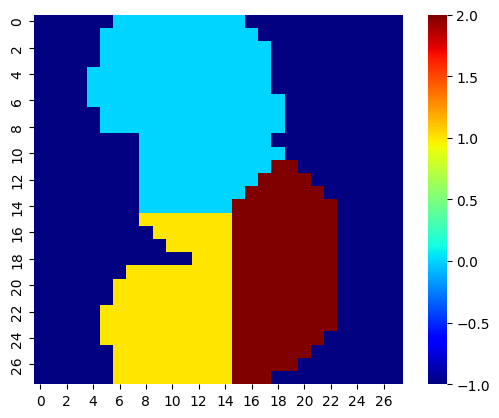

In [49]:
import seaborn as sns

centroids = np.array([[1.1, 1.1], [1.1, 27], [27, 27]])
print(centroids.shape[0])
def cluster_attention_map(map, control_points, weight_threshold=0.1):
    centroids = np.zeros(control_points.shape)
    centroids[:,0] = control_points[:,1]
    centroids[:,1] = control_points[:,0]
    num_rows = 28
    num_cols = 28
    points = np.array([(i,j) for i in range(num_cols) for j in range(num_rows)])
    weights = map.flatten()
    #print(weights)

    # use euclidean distance to cluster heatmap
    distances = np.sqrt(((points - centroids[:,np.newaxis])**2).sum(axis=2))
    distances_to_centroid = np.min(distances, axis=0)
    clustered_points = np.argmin(distances, axis=0)
    clustered_points[weights<weight_threshold] = -1
    #points = np.array([(i,j) for i in range(num_rows) for j in range(num_cols)])
    #clustered_points = clustered_points.reshape(num_rows, num_rows)

    # compute the weights
    centroids_weight = np.zeros(centroids.shape[0])
    new_centroids = np.zeros(centroids.shape)
    
    for i in range(centroids.shape[0]):
        points_in_cluster = points[clustered_points == i]
        #print(points_in_cluster.shape)
        
        weights_in_cluster = weights[clustered_points == i ]
        #print(weights_in_cluster)
        #weights_in_cluster[weights_in_cluster<weight_threshold] = 0

        if np.sum(weights_in_cluster) > 0:
            new_centroids[i] = np.sum(points_in_cluster.T * weights_in_cluster, axis=1) / np.sum(weights_in_cluster)

            distances_in_cluster = distances_to_centroid[clustered_points == i]
            distances_in_cluster[distances_in_cluster < 1] = 1

            weights_by_distances = np.multiply(weights_in_cluster, 1. / np.power(distances_in_cluster, 1))

            centroids_weight[i] = np.sum(weights_by_distances)
            # print(f"centroids_weight {i} {centroids_weight[i]}")

        else:
            new_centroids[i] = np.array([14, 14])
            centroids_weight[i] = 0

    return clustered_points, centroids_weight, new_centroids 

id = 1
clustered_points, centroids_weight, _ = cluster_attention_map(saliency_map[id], centroids, weight_threshold=0.1)
clustered_points = clustered_points.reshape(28,28)
print(clustered_points.shape)
sns.heatmap(clustered_points,  square=True, cmap="jet")
ax[1].scatter(control_points[:,1],control_points[:,0], color="w", marker="x" )


[[ 7.22250624 22.44329603]
 [ 6.25945321 18.        ]
 [ 8.76792709 20.        ]
 [15.59929115 19.49161795]
 [13.         15.        ]
 [ 8.4729271  13.95619512]
 [13.5970051   9.80582775]
 [14.52580168  7.        ]
 [11.24916491  5.25      ]
 [19.13921604  5.93487108]
 [20.32683455  9.79827057]
 [19.68923339 15.71972889]
 [17.92383739 21.85632941]
 [ 7.22250624 22.44329603]]
(28, 28)
centroids_weight [7.97449775 2.92669445 4.16888399 2.75351267 5.82350013 2.82310235
 4.89847194 5.05882656 6.04537953 3.49995183 1.21974368 1.0472394
 2.74292635 0.        ]
<svg version="1.0" xmlns="http://www.w3.org/2000/svg" height="28" width="28"><path d=" M 7.2225062434054275,22.443296031350947 C 4.817198089009279,20.758552620221018 4.219301291996818,18.0 6.259453211228697,18.0 C 6.952152477404482,18.0 8.080965725025289,18.9 8.767927094830492,20.0 C 10.440552675760149,22.678299275466312 12.571167670058642,22.51974142085045 15.599291145312584,19.49161794559651 C 18.747403388535417,16.34350570237367 17

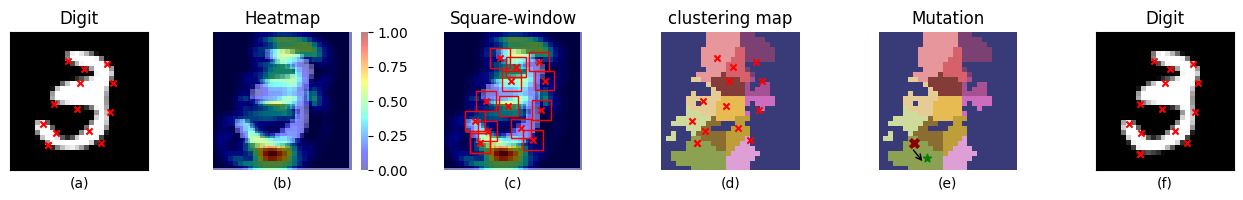

In [273]:
from population import generate_digit, load_mnist_test
from mutation_manager import end_or_middle_points
from digit_mutator import DigitMutator
from matplotlib.patches import Rectangle
# test_x, test_y = load_mnist_test(popsize=3, number=7)
id = 4

ind = generate_digit(id, X[id], number)
mutator = DigitMutator(ind)

# gather all candidates to be mutated
control_points = end_or_middle_points(mutator.svg_path, "end")

control_points = np.array(control_points)
print(control_points)

print(saliency_map[0].shape)


f, ax = plt.subplots(nrows=1, ncols=6, figsize=(13, 2))
#f.tight_layout()
# attention map
ax[0].imshow(ind.purified.reshape(28,28), cmap="gray")

ax[0].scatter(control_points[:,0],control_points[:,1], color="r", marker="x",s = 20)
ax[0].set_title("Digit")
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("(a)")

ax[1].imshow(ind.purified.reshape(28,28), cmap="gray")
sns.heatmap(saliency_map[id], ax=ax[1], square=True, cmap="jet", alpha = 0.5)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title("Heatmap")
ax[1].set_xlabel("(b)")

ax[2].imshow(ind.purified.reshape(28,28), cmap="gray")
sns.heatmap(saliency_map[id], ax=ax[2], square=True,cbar=False, cmap="jet", alpha = 0.5)
ax[2].scatter(control_points[:,0],control_points[:,1], color="r", marker="x",s = 20)
w = 4
for i in range(control_points.shape[0]):
    ax[2].add_patch(Rectangle(xy = (control_points[i,0]-w/2,control_points[i,1]-w/2),
                            width = w,
                            height = w,
                            linewidth = 1,
                            color = "r",
                            fill = False))

ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_title("Square-window")
ax[2].set_xlabel("(c)")

# cluster map
#ax[1].imshow(X[id])
clustered_points, centroids_weight, new_centroids = cluster_attention_map(saliency_map[id], control_points, weight_threshold=0.1)
print(f"centroids_weight {centroids_weight}")

clustered_points = clustered_points.reshape(28,28)

clustered_points2 = clustered_points+5
clustered_points2[clustered_points2<4.5] = 0 

sns.heatmap(clustered_points2, ax=ax[3], square=True,cbar=False, cmap="tab20b", alpha = 1)
#sns.heatmap(clustered_points,ax=ax[1], square=True,  alpha = 1,cmap="jet")

ax[3].scatter(control_points[:,0],control_points[:,1], color="r", marker="x",s=20 )
ax[3].set_title("clustering map")
ax[3].set_yticks([])
ax[3].set_xticks([])
ax[3].set_xlabel("(d)")
#ax[4].imshow(X[id], cmap="gray")
#ax[4].imshow(clustered_points, cmp="jet")

sns.heatmap(clustered_points2, ax=ax[4], square=True,cbar=False, cmap="tab20b", alpha = 1)
#sns.heatmap(clustered_points,ax=ax[1], square=True,  alpha = 1,cmap="jet")
#ax[4].scatter(control_points[:,0],control_points[:,1], color="r", marker="x",s = 20 )
ax[4].scatter(new_centroids[0,1]+1,new_centroids[0,0]+1, color="g", marker="*" )
ax[4].scatter(control_points[0,0],control_points[0,1], color="darkred", marker="x",linewidths = 3 )
ax[4].annotate("",xy = (control_points[0,0]-0.5, control_points[0,1]+1), 
               xytext = (new_centroids[0,1]+0.5, new_centroids[0,0]+2), 
               arrowprops=dict(arrowstyle="<-"))
ax[4].set_title("Mutation")
ax[4].set_xlabel("(e)")
ax[4].set_yticks([])
ax[4].set_xticks([])

# axins = ax[4].inset_axes((6,21, 4,5))

print(ind.xml_desc)
xy = ((new_centroids[0,1] - control_points[0,0])*0.8 + control_points[0,0], 
      (new_centroids[0,0] - control_points[0,1])*0.8 + control_points[0,1])
print()
print("new_centroid",new_centroids[0,1], new_centroids[0,0])
print("mutation point",control_points[0,0], control_points[0,1] )
print(xy)
print()

#print(new_xml_desc)

import copy
ind2 = copy.deepcopy(ind)
ind2.reset()

mutator2 =DigitMutator(ind2)
print("mutant_vector 1", mutator2.svg_path)
mutant_vector = mutator2.svg_path.replace(str(control_points[0,0])+","+str(control_points[0,1]) , 
                                       str(xy[0])+","+str(xy[1]))
#print("mutant_vector 2", mutant_vector)

import rasterization_tools
import vectorization_tools
ind2.xml_desc = vectorization_tools.create_svg_xml(mutant_vector)
ind2.purified = rasterization_tools.rasterize_in_memory(ind2.xml_desc)
#print(ind2.xml_desc)

mutator2 =DigitMutator(ind2)
control_points2 = end_or_middle_points(mutator2.svg_path, "end")

control_points2 = np.array(control_points2)
print(control_points2)
ax[5].imshow(ind2.purified.reshape(28,28), cmap="gray")
ax[5].scatter(control_points2[:,0],control_points2[:,1], color="r", marker="x",s = 20)
ax[5].set_title("Digit")
ax[5].set_yticks([])
ax[5].set_xticks([])
ax[5].set_xlabel("(f)")

f.tight_layout()
f.savefig("MNIST methods.svg", dpi = f.dpi)



<svg version="1.0" xmlns="http://www.w3.org/2000/svg" height="28" width="28"><path d=" M 8.446631992117323,24.139256110348754 C 4.817198089009279,20.758552620221018 4.219301291996818,18.0 6.259453211228697,18.0 C 6.952152477404482,18.0 8.080965725025289,18.9 8.767927094830492,20.0 C 10.440552675760149,22.678299275466312 12.571167670058642,22.51974142085045 15.599291145312584,19.49161794559651 C 18.747403388535417,16.34350570237367 17.96991907928323,15.000000000000002 13.000000000000002,15.000000000000002 C 10.864918693812445,15.000000000000002 8.827735887664971,14.53028780557504 8.472927097450064,13.95619512350009 C 7.391737874011396,12.206794211706221 9.957017232760801,10.128985921227214 13.597005101449037,9.805827748712257 C 17.834208743791585,9.429648751685383 18.41355483689599,7.679485825415577 14.5258016836078,7.0 C 12.952358828489572,6.725 11.477872281674905,5.937500000000001 11.24916491290854,5.250000000000002 C 10.580386160488619,3.2396345501731956 16.47498277033188,3.751296478

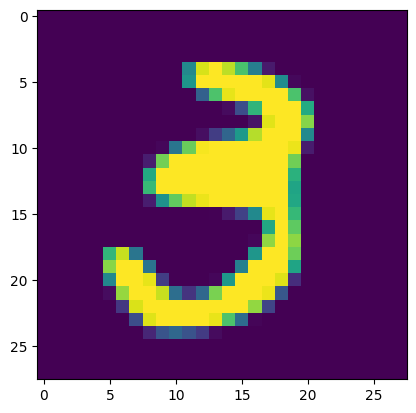

In [243]:
print(ind.xml_desc)
xy = ((new_centroids[0,1] - control_points[0,0])*0.8 + control_points[0,0], 
      (new_centroids[0,0] - control_points[0,1])*0.8 + control_points[0,1])
print()
print("new_centroid",new_centroids[0,1], new_centroids[0,0])
print("mutation point",control_points[0,0], control_points[0,1] )
print(xy)
print()

#print(new_xml_desc)

import copy
ind2 = copy.deepcopy(ind)
ind2.reset()
mutator2 =copy.deepcopy(mutator)

mutant_vector = mutator2.svg_path.replace(str(control_points[0,0])+","+str(control_points[0,1]) , 
                                       str(xy[0])+","+str(xy[1]))
#print(mutant_vector)



import rasterization_tools
import vectorization_tools
ind2.xml_desc = vectorization_tools.create_svg_xml(mutant_vector)
ind2.purified = rasterization_tools.rasterize_in_memory(ind2.xml_desc)
print(ind2.purified.shape)
plt.imshow(ind.purified.reshape(28,28))

In [41]:
np.exp(centroids_weight) / np.sum(np.exp(centroids_weight), axis=0)

array([6.69001125e-01, 6.32671943e-04, 1.56003229e-04, 7.75355443e-04,
       2.45145665e-02, 8.14319622e-04, 8.75769090e-04, 3.03116126e-01,
       5.60960361e-05, 4.28878450e-05, 1.50794271e-05])

In [51]:
new_centroids 

array([[24.45119411,  9.41675583],
       [18.1207842 ,  6.15485982],
       [20.65470217, 10.37514669],
       [22.60093916, 15.7021235 ],
       [14.43254528, 10.92923117],
       [10.80222773, 11.5894689 ],
       [ 6.5273692 , 15.80633569],
       [ 3.12077789, 12.94848844],
       [11.2213576 , 19.17506902],
       [17.30134103, 18.22612076],
       [14.        , 14.        ]])

In [76]:
control_points

array([[ 7.22250624, 22.44329603],
       [ 6.25945321, 18.        ],
       [ 8.76792709, 20.        ],
       [15.59929115, 19.49161795],
       [13.        , 15.        ],
       [ 8.4729271 , 13.95619512],
       [13.5970051 ,  9.80582775],
       [14.52580168,  7.        ],
       [11.24916491,  5.25      ],
       [19.13921604,  5.93487108],
       [20.32683455,  9.79827057],
       [19.68923339, 15.71972889],
       [17.92383739, 21.85632941],
       [ 7.22250624, 22.44329603]])

In [151]:
clustered_points2


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18, 18,
        19, 19, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18, 18,
        19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18, 18,
        19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18, 18, 17,
        17, 19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18, 18, 17,
        17, 19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18, 17, 17,
        17, 19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 17, 17, 17,
        17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 17, 17, 17,
        17, 19,  0,  0,  